In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df = pd.read_csv("./data/wvs/wave7.csv")
df.head()

C:\Users\WordPress\AppData\Local\Temp\ipykernel_12812\3953007284.py:7: DtypeWarning: Columns (349,351) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/wvs/wave7.csv")


,Unnamed: 0,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,...,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party,Economy ISO3,Economy Name,Year,WPFI
0,0,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79
1,1,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79
2,2,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79
3,3,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,NaN,NaN,NaN,NaN,NaN,NaN,AND,Andorra,2018,77.79
4,4,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79


In [29]:
df.columns

Index(['Unnamed: 0', 'version', 'doi', 'A_WAVE', 'A_YEAR', 'A_STUDY',
       'B_COUNTRY', 'B_COUNTRY_ALPHA', 'C_COW_NUM', 'C_COW_ALPHA',
       ...
       'v2psorgs', 'v2psprbrch', 'v2psprlnks', 'v2psplats', 'v2xnp_client',
       'v2xps_party', 'Economy ISO3', 'Economy Name', 'Year', 'WPFI'],
      dtype='object', length=618)

# Feature engineering the trust index
We want to look at different aspects of trust: Trust in general, trust towards national institutions and trust torwards international institutions.

|kind of trust | questions |
| -----|-----|
| Baseline trust| Q53-Q63|
| National trust | Q64-Q81 |
| International trust | Q82-Q89|

For each we are going to do the following steps:
- Impute missing values with median
- Normalize the values with `MinMaxScaler` from `sklearn` package
- Avgerage the questions

In [4]:
trust_questions = [f"Q{i}" for i in range(53, 90)]
base_trust_qustions = [f"Q{i}" for i in range(53, 64)]
national_trust_questions  = [f"Q{i}" for i in range(64, 82)]
international_trust_questions = [f"Q{i}" for i in range(82, 90)]

## 1. Missing values 
While there are no missing values in terms of no information given, there are still values, there are still answers like "I don't know (-1)" or "not applicable (-3)":
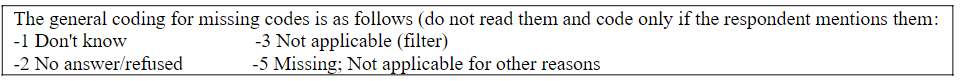

In [ ]:
na_values = any(df.loc[:, trust_questions].isna().sum()/len(df) != 0)
print("There are missing values in the trust data" if na_values else "There are no NA values")

There are no NA values


Text(0.5, 1.0, 'Missing values (in %) after question')

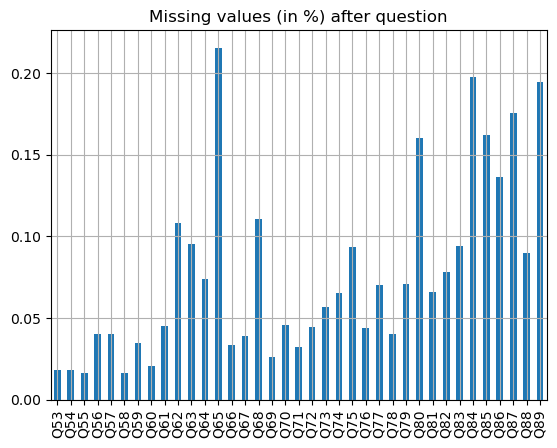

In [22]:
((df.loc[:, trust_questions] <= 0).sum(axis=0)/ len(df)).plot(kind = "bar")
plt.grid(True)
plt.title("Missing values (in %) after question")

Especially the last international questions a lot of missing values are detectable. Reasons for missing values might be:
- Institutions don't exist. We see a spike in the armed forces. These might not exist for whatever reason
- Countries might not be part of international alliances like NATO
- The question if people trust other people of another nationality has a suspicous amount of missing values


We will need to look further into this. But for now we will just use the median to fill these missing values. But grouped by the country. There still are some aspects to consider:
- Median will be computed on positive values only
- The data of the country will be used for the median

This won't be a simple `fillna`, rather we will do the imputation with a dictionary

In [5]:
# create a median dict with all the relevant values
median_dict = {}
countries = df.B_COUNTRY.unique()

for ct in countries:
    median_dict[ct] = {}

for tq in trust_questions:
    for ct in countries:
        median_dict[ct][tq] = df.loc[(df[tq] > 0) & (df.B_COUNTRY == ct), tq].median()

In [6]:
# now populate the dataframe with the median values
for tq in trust_questions:
    df[tq] = df.loc[:, [tq, "B_COUNTRY"]].apply(lambda row: median_dict[row["B_COUNTRY"]][tq] if row[tq] <= 0 else row[tq], axis=1)

Text(0.5, 1.0, 'Missing values (in %) after question')

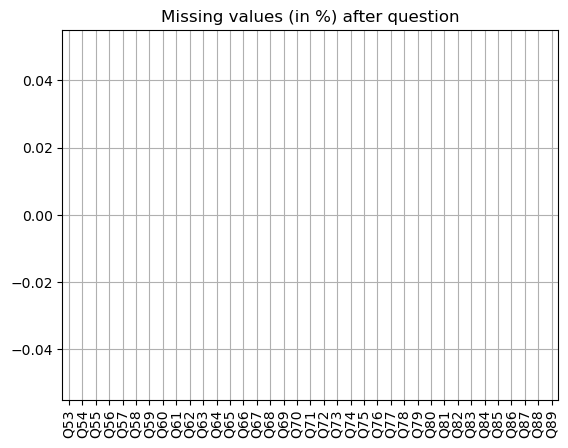

In [7]:
((df.loc[:, trust_questions] <= 0).sum(axis=0)/ len(df)).plot(kind = "bar")
plt.grid(True)
plt.title("Missing values (in %) after question")

## 2. MinMaxScaling the data
The transformation will be:
$$
x_{norm} = \frac{x - x_{min}}{x_{max}-x_{min}}
$$

In [8]:
scaler = MinMaxScaler()
scaler.fit(df.loc[:, trust_questions])
df.loc[:, trust_questions] = scaler.transform(df.loc[:, trust_questions])

## 3. Rowwise mean over the questions

In [9]:
df["base_distrust_index"] = df.loc[:, base_trust_qustions].mean(axis=1)
df["national_distrust_index"] = df.loc[:, national_trust_questions].mean(axis=1)
df["international_distrust_index"] = df.loc[:, international_trust_questions].mean(axis=1)

<Axes: ylabel='Frequency'>

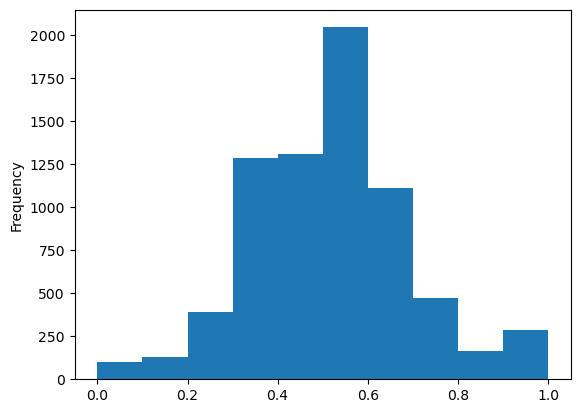

In [10]:
df.international_distrust_index.plot(kind="hist")

## Transforming these steps into a utils function

In [11]:
def attach_distrust_index(df: pd.DataFrame) -> pd.DataFrame:
  """
  # Creating a trust index

  Attaches trust indeces for base, national and international trust to the dataframe.
  Furthermore, all trust related questions are preprocessed by imputing with the median and MinMaxScaled.

  Parameters:
    df(pd.DataFrame): the wave7.csv dataframe stored by the data_filter_merge.ipynb
  
  Returns:
    pd.DataFrame: Processed dataframe with the distrust indeces in `base_distrust_index`, `national_distrust_index`, `international_distrust_index`
  """
  trust_questions = [f"Q{i}" for i in range(53, 90)]
  base_trust_qustions = [f"Q{i}" for i in range(53, 64)]
  national_trust_questions  = [f"Q{i}" for i in range(64, 82)]
  international_trust_questions = [f"Q{i}" for i in range(82, 90)]

  result = df.copy()

  # 1. imputing with median --------------------------------------------
  # create a median dict with all the relevant values
  median_dict = {}
  countries = result.B_COUNTRY.unique()

  for ct in countries:
      median_dict[ct] = {}

  for tq in trust_questions:
      for ct in countries:
          median_dict[ct][tq] = result.loc[(result[tq] > 0) & (result.B_COUNTRY == ct), tq].median()
  
  # now populate the dataframe with the median values
  for tq in trust_questions:
      result[tq] = result.loc[:, [tq, "B_COUNTRY"]].apply(lambda row: median_dict[row["B_COUNTRY"]][tq] if row[tq] <= 0 else row[tq], axis=1)
    
  # 2. Minmax scaling --------------------------------------------
  scaler = MinMaxScaler()
  scaler.fit(result.loc[:, trust_questions])
  result.loc[:, trust_questions] = scaler.transform(result.loc[:, trust_questions])

  # 3. Creating trust indeces by rowwise mean --------------------------------------------
  result["base_distrust_index"] = result.loc[:, base_trust_qustions].mean(axis=1)
  result["national_distrust_index"] = result.loc[:, national_trust_questions].mean(axis=1)
  result["international_distrust_index"] = result.loc[:, international_trust_questions].mean(axis=1)

  return result

In [12]:
# testing implementation:
df = pd.read_csv("./data/wvs/wave7.csv")

attach_distrust_index(df)

C:\Users\Carsten\AppData\Local\Temp\ipykernel_23356\1319931405.py:2: DtypeWarning: Columns (349,351) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/wvs/wave7.csv")


,Unnamed: 0,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,...,v2psplats,v2xnp_client,v2xps_party,Economy ISO3,Economy Name,Year,WPFI,base_distrust_index,national_distrust_index,international_distrust_index
0,0,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79,0.515152,0.098039,0.333333
1,1,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79,0.545455,0.745098,0.666667
2,2,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79,0.681818,0.549020,0.500000
3,3,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,NaN,NaN,NaN,AND,Andorra,2018,77.79,0.727273,0.647059,0.666667
4,4,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,...,-999.0,-999.0,-999.0,AND,Andorra,2018,77.79,0.651515,0.529412,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7281,7281,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2022,2,528,NLD,210,NTH,...,NaN,NaN,NaN,NLD,Netherlands,2022,77.93,0.696970,0.740741,0.791667
7282,7282,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2022,2,528,NLD,210,NTH,...,NaN,NaN,NaN,NLD,Netherlands,2022,77.93,0.454545,0.296296,0.333333
7283,7283,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2022,2,528,NLD,210,NTH,...,NaN,NaN,NaN,NLD,Netherlands,2022,77.93,0.454545,0.574074,0.541667
7284,7284,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2022,2,528,NLD,210,NTH,...,NaN,NaN,NaN,NLD,Netherlands,2022,77.93,0.424242,0.666667,0.666667
